# IMDB Dataset
This paper aims to evaluate a suitable approach to classify movie-reviews into either good ones, or bad ones.
## Preparation
In this section the dataset is imported, dependencies are installed, and the basic structure of the data is displayed.

In [115]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import seaborn as sns

#Importing the dataset
df = pd.read_csv('./ds.csv')
#df.head()

In [116]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

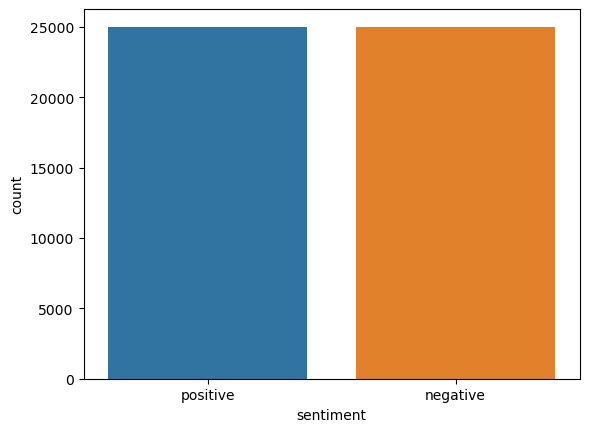

In [117]:
sns.countplot(df['sentiment'])

## Pre-Processing
In this section the sentiment field is changed into a binary value and the reviews are tokenized, lemmatized, and visualized.

In [118]:
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])


In [120]:
independent = df['review']
dependent = df['sentiment']
nltk.download('stopwords')

from nltk import WordNetLemmatizer
lem = WordNetLemmatizer()

ps = PorterStemmer()
corpus = []

for i in range(len(independent)):
    review = re.sub("<[^<>]*>","", independent[i])
    review = re.sub("[^a-zA-Z]", " ", review)
    review = review.lower().split()
    #review = [ps.stem(word) for word in review if word not in set(stopwords.words("english"))]
    review = [lem.lemmatize(word) for word in review if word not in set(stopwords.words("english"))]
    review = " ".join(review)
    corpus.append(review)




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilweber/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features=10000)
X = cv.fit_transform(corpus).toarray()

The following code splits the dataset into training and testing. 

In [123]:
X_train, X_test, Y_train, Y_test = train_test_split(X, df['sentiment'], test_size=0.15, random_state=666)


In [124]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


((42500, 10000), (7500, 10000), (42500,), (7500,))

## Multinomial Naive Bayes
The MNB algorithm is a model based on the Bayes theorem, which is explained in more detail in the corresponding paper.

In [125]:
mnb = MultinomialNB()
mnb.fit(X_train, Y_train)

MultinomialNB()

In [126]:
pred = mnb.predict(X_test)

In [127]:
print(accuracy_score(Y_test , pred))
print(confusion_matrix(Y_test , pred))
print(classification_report(Y_test , pred))

0.8637333333333334
[[3183  498]
 [ 524 3295]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      3681
           1       0.87      0.86      0.87      3819

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500



In [128]:
pickle.dump(cv,open('./model/CV.pickle', 'wb'))
pickle.dump(mnb, open('./model/MNB.pickle', 'wb')) 

In [129]:
save_cv = pickle.load(open('./model/CV.pickle', 'rb'))
model = pickle.load(open('./model/MNB.pickle', 'rb'))

In [130]:
def test_model(sentence):
    sen = save_cv.transform([sentence]).toarray()
    res = model.predict(sen)[0]
    if res == 1:
        return 'Positive review'
    else:
        return 'Negative review'

## Bi/Trigram
This section was just a simple test to see, whether changing the ngram_range makes a difference or not. 

In [132]:
cv_ngram = TfidfVectorizer(max_features=5000, ngram_range=(2,3))
X_ngram = cv_ngram.fit_transform(corpus).toarray()

In [133]:
X_train_ngram, X_test_ngram, Y_train_ngram, Y_test_ngram = train_test_split(X, df['sentiment'], test_size=0.5, random_state=666)

In [134]:
mnb_ngram = MultinomialNB()
mnb_ngram.fit(X_train_ngram, Y_train_ngram)

MultinomialNB()

In [135]:
pred_ngram = mnb_ngram.predict(X_test_ngram)

In [136]:
print(accuracy_score(Y_test_ngram , pred_ngram))
print(confusion_matrix(Y_test_ngram , pred_ngram))
print(classification_report(Y_test_ngram , pred_ngram))

0.85756
[[10650  1733]
 [ 1828 10789]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86     12383
           1       0.86      0.86      0.86     12617

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



## Logistic Regression
This chapter creates a logistic regression model, which is explained in detail in the corresponding paper.

In [169]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [170]:
pred_clf = clf.predict(X_test)

In [139]:
print(accuracy_score(Y_test , pred_clf))
print(confusion_matrix(Y_test , pred_clf))
print(classification_report(Y_test , pred_clf))

0.8958666666666667
[[3254  427]
 [ 354 3465]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3681
           1       0.89      0.91      0.90      3819

    accuracy                           0.90      7500
   macro avg       0.90      0.90      0.90      7500
weighted avg       0.90      0.90      0.90      7500



In [184]:
def test_clf(sentence):
    sen = save_cv.transform([sentence]).toarray()
    res = clf.predict(sen)[0]
    if res == 1:
        return 'Positive'
    else:
        return 'Negative'

# SGD Classifier
This section creates an SGD Classifier, which is optimizing a logistic regression model.

In [155]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=0, loss="log", penalty="l2").fit(X_train, Y_train)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [156]:
pred_sgd = sgd.predict(X_test)

In [157]:
print(accuracy_score(Y_test , pred_sgd))
print(confusion_matrix(Y_test , pred_sgd))
print(classification_report(Y_test , pred_sgd))

0.8868
[[3178  503]
 [ 346 3473]]
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      3681
           1       0.87      0.91      0.89      3819

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500



In [145]:
def test_sgd(sentence):
    sen = save_cv.transform([sentence]).toarray()
    res = sgd.predict(sen)[0]
    if res == 1:
        return 'Positive review'
    else:
        return 'Negative review'

## User Testing
This section simply tests a few self-written cases, to figure out any anomalities in the model. 

In [187]:
testX = [
    ["I really liked the film, although the bad guy did not die in the end, i think it really was a success!", "Positive"],
    ["This movie just showed me that going to the cinema really is not worth it anymore, thanks for nothing",  "Negative"],
    ["The best movie ever!", "Positive"],
    ["I really hated this, why should anyone want to watch that?", "Negative"]
]

In [177]:
for i in testX:
    print(i)

['I really liked the film, although the bad guy did not die in the end, i think it really was a success!']
['This movie just showed me that going to the cinema really is not worth it anymore, thanks for nothing']
['The best movie ever!']


In [189]:
count = 0
for i in testX:
    if test_clf(i[0]) == i[1]:
        count += 1
        
print(1/len(testX)*count)

0.75


### Negations
The following shows an example for the model having issues dealing with negations in reviews.

In [190]:
print(testX[1])
test_clf(testX[1][0])

['This movie just showed me that going to the cinema really is not worth it anymore, thanks for nothing', 'Negative']


'Positive'